# WhatshAppened
A small WhatsApp chat export analytics tool

## Creating the chat export
The export can be created with whatsapp, but only one chat at a time
1. Open a chat (group or direct, works both)
2. Click on the options icon in the upper right corner
3. Click on more
4. Click on "Send history via e-mail"
5. Send the history to your account
6. Sate the .txt file, this is the file you need

## Load the text file
The constructor of WALog expects the text file from the export and optional the language and exporter_name.

At this point in time, the only language supported is 'de'.

exporter_name replaces the "you" in messages like "You have changed the group picture" or "You have been removed".

In case that you want to merge or rename certain sendery, use the rename_sender method.

In [6]:
from WALog import WALog

log = WALog('example.txt', language='de', exporter_name='John Doe')
log.parse(verbose=True)

Read 65 lines from example.txt
Merged into 47 messages
Parsing completed


## Simple statistics
The WAStats class provides some simple statistics on the chat messages without dependencies on larger packages. 

In [7]:
from WAStats import WAStats

stat = WAStats(log)
stat.show_stats()

Participants:
{'+49 1111 1212121', '???', 'Baron von Tuff', 'System', 'Jack the Flipper', 'Carmen Santiago', 'Nikolaus', 'Mrs. Bushman', 'John Doe'}
Message types:
{'remove', 'topic', 'add', 'security', 'message', 'unknown', 'picture', 'quit'}
Messages per participant:
+49 1111 1212121 : 6
??? : 2
Baron von Tuff : 4
System : 5
Jack the Flipper : 13
Carmen Santiago : 1
Nikolaus : 1
Mrs. Bushman : 13
John Doe : 2


## Fun with pandas
The real fun begins with the pandas package. Here we slice and dice and visualize different views on the data. It requires pandas, numpy, and pyplot. I use the font ´Segoe UI Emoji´ here for plotting, as the default font does not include many emojis.

In [8]:
import pandas as pd
import numpy as np
from WAPanda import WAPanda
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family='Segoe UI Emoji')

pan = WAPanda(log)


## Who is the big talker?
First real example is plotting the overview of total messages per participant. 
For this I want to focus on messages only, updates like changes of group picture, security numbers, etc. should be omited. Then we count the number of entries/values per sender and plot it as bar plot.

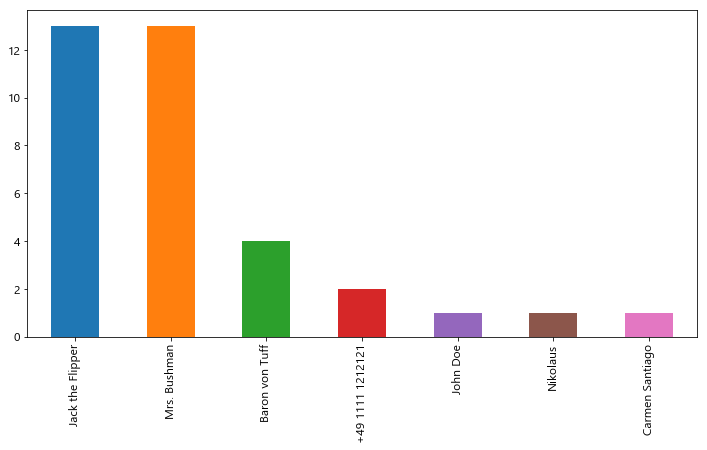

In [9]:
is_message = pan._df.type == 'message'
messages = pan._df[is_message]
messages.who.value_counts().plot(kind='bar', figsize=(12,6), fontsize=12)

Now we know who talks that much, but what about the day of the week? Weekend spamming or killing time during work? The overview grouped by weekday helps!

Text(0,0.5,'number of messages')

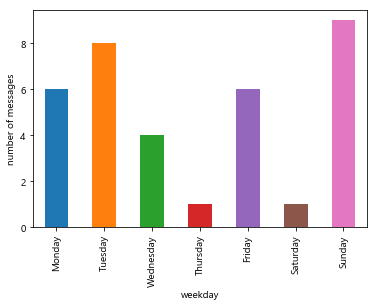

In [10]:
weekday = messages.timestamp.dt.date.groupby(pan._df.timestamp.dt.weekday).aggregate('count')
weekday.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday.plot(kind='bar')
plt.xlabel('weekday')
plt.ylabel('number of messages')

Nightowl or early bird? Let's take a look at the distribution of messages during the day.

Text(0,0.5,'number of messages')

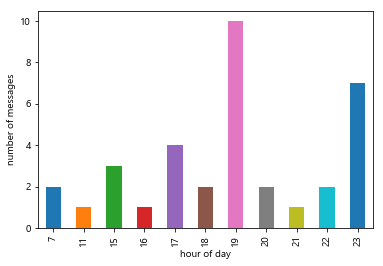

In [11]:
weekday = messages.timestamp.dt.date.groupby(pan._df.timestamp.dt.hour).aggregate('count')
weekday.plot(kind='bar')
plt.xlabel('hour of day')
plt.ylabel('number of messages')

We have seen the distribution over weekday and over time of day. But it's obvious there should be a difference between the distribution on a Monday vs. a Saturday. So let's have a 2D plot on number of messages by hour of day and weekday.
As bar plots are usually not as intuitive and easy to see in 2D as in 1D, I use a different form of visualization. Plotting as image. The brighter the pixels are, the higher the message count is.

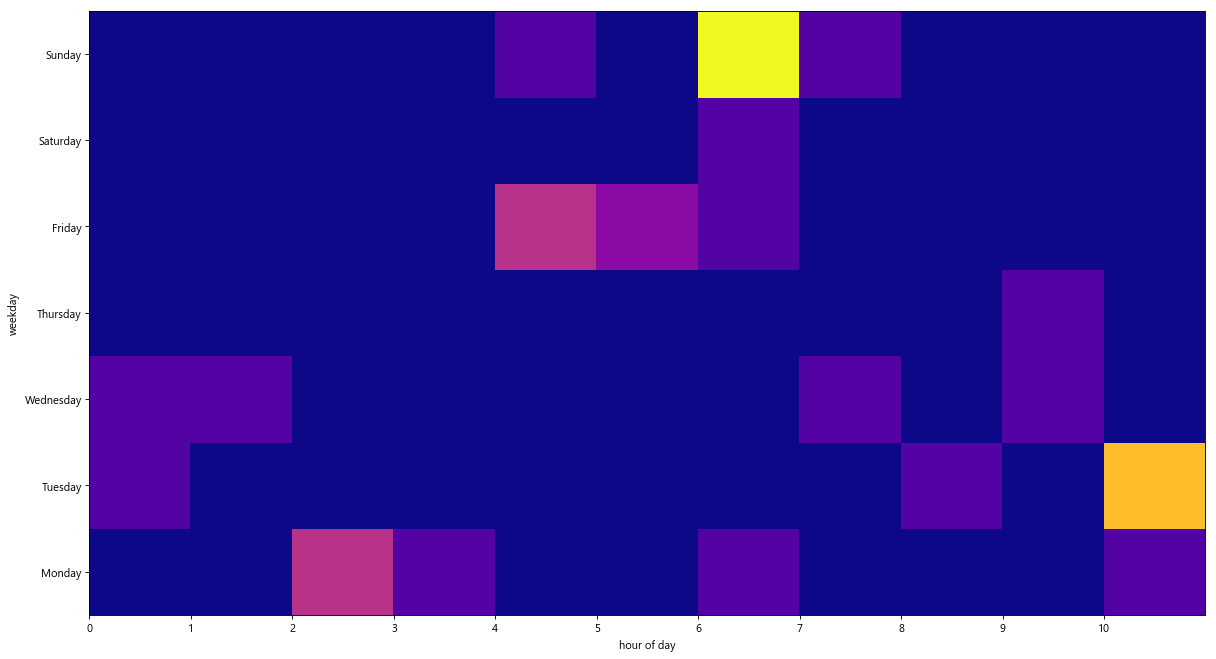

In [12]:
pvt = pd.pivot_table(messages[['timestamp']], index=messages.timestamp.dt.weekday, columns=messages.timestamp.dt.hour, aggfunc='count', fill_value=0)
fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.pcolor(pvt, cmap='plasma')
pvt.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.yticks(np.arange(0.5, len(pvt.index), 1), pvt.index)
plt.xticks(np.arange(0, len(pvt.columns), 1))
plt.xlabel('hour of day')
plt.ylabel('weekday')
plt.show()

## Emojis ##
It's always fun to see what kind of emojis are used, and how different people are using different emojis. Here we have a few examples on how to get a short overview on the emojis used by different people.

The first example shows the top 10 emojis per person. If the person did not use 10 different emojis it only shows the emojis used. In compact format there are just the emojis, in the regular format the share per emoji is given. The functions are not very performant, so calculation takes some time.

In [13]:
pan.emoji_stats()
pan.top_emojis(number_top=10, compact=True)

Carmen Santiago : 
John Doe        : 
Nikolaus        : 
Baron von Tuff  : 😂 🙈 👞 👉 😄 👍 😜
+49 1111 1212121: 🙈
Jack the Flipper: 🙈 😜 😴 😊 😉
Mrs. Bushman    : 🙈 😄


## Resampling ##
Messages can be seen as events over time. At some points in time we have an event, or even more than one, and at other points in time we don't have any events. To analyze the data as time series with equal time slots we can resample the data, aggregate messages if we have more than one, or set the time slots to 0 if there weren't any. Pandas luckily makes this quite easy. So let's look at the messages per month:

Text(0,0.5,'number of messages')

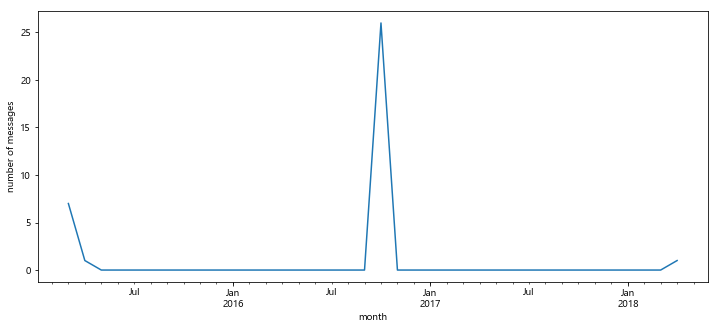

In [14]:
is_message = pan._df.type == 'message'
messages = pan._df[is_message]
spiketrain = messages.groupby('timestamp').aggregate('count').who.resample('M').sum()
spiketrain.plot(figsize=(12,5))
plt.xlabel('month')
plt.ylabel('number of messages')

Now one of the more messy plots: the time series for each sender. If you have more than a few sender this is just mayhem. But for small groups this can give nice insights, for example if one person is gradually reducing it's activity or if someone starts sending more and more messages. 

Text(0,0.5,'number of messages')

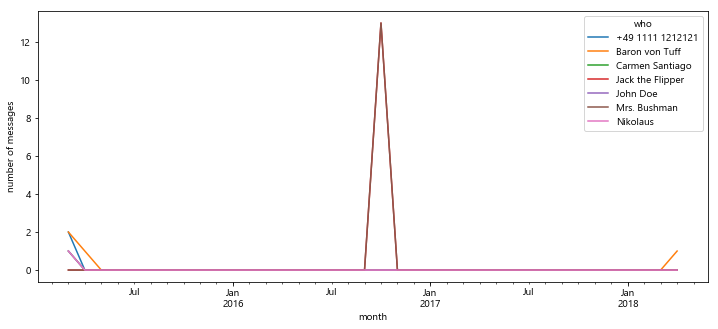

In [15]:
piv = pd.pivot_table(aggfunc='count', columns=messages.who, data=messages[['who', 'timestamp']], index=messages.timestamp, fill_value=0)
piv_resample = piv.who.resample('M').sum()
piv_resample.plot(figsize=(12,5))
plt.xlabel('month')
plt.ylabel('number of messages')

More examples to come. Check back every couple of weeks. (And better examples. This set is dull.)